<a href="https://colab.research.google.com/github/anis191-19/online-bidding-system/blob/main/Copy_of_Facial_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Facial Emotion Detection — **Grayscale-only**, **Fast**, Auto-Setup (DenseNet121 & ResNet50)

This notebook is **plug & play** for your dataset:
- CSV path pre-set to: `/content/drive/MyDrive/EmotionDetectionDataset/fer2013.csv`
- Auto-mounts Drive, converts the CSV to **grayscale** PNGs at 224×224 into `/content/datasets/fer2013_csv/train|val|test`
- Trains **DenseNet121** (toggle to ResNet50), with 224×224 resizing, rescaling, feature dropout, and augments (flip/rotation/zoom)
- Shows confusion matrix, ROC (OvR) + AUCs, accuracies (train/val/test), and accuracy vs loss curves


## 1) Setup — install libraries (Colab)

In [2]:
# Install exact versions for stability
!pip install -q tensorflow==2.19.0 scikit-learn matplotlib seaborn pandas opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 832.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.0 MB/s eta 0:00:00


## 2) Imports & Reproducibility

In [ ]:

import os, glob, json, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3) Auto materialize `fer2013.csv` → grayscale PNGs (224×224)

In [ ]:



CSV_PATH    = "/content/drive/MyDrive/Dataset/fer2013.csv"
OUTPUT_ROOT = "/content/datasets/fer2013_csv"
SAVE_W, SAVE_H = 224, 224  # save at target size for speed

os.makedirs(OUTPUT_ROOT, exist_ok=True)

df = pd.read_csv(CSV_PATH)
id2label  = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}
usage_map = {'Training':'train','PublicTest':'val','PrivateTest':'test'}

# Create split/class folders
for split in ['train','val','test']:
    for c in id2label.values():
        os.makedirs(os.path.join(OUTPUT_ROOT, split, c), exist_ok=True)

print("Converting fer2013.csv to **GRAYSCALE** PNGs (224x224)...")
for idx, row in df.iterrows():
    emotion = int(row['emotion'])
    pixels  = np.fromstring(row['pixels'], dtype=np.uint8, sep=' ')
    img     = pixels.reshape(48, 48)  # grayscale
    img     = cv2.resize(img, (SAVE_W, SAVE_H), interpolation=cv2.INTER_AREA)

    split = usage_map[row['Usage']]
    cls   = id2label[emotion]
    out_dir  = os.path.join(OUTPUT_ROOT, split, cls)
    out_path = os.path.join(out_dir, f"img_{idx}.png")
    cv2.imwrite(out_path, img)  # 1-channel PNG

# Quick sanity check
n_train = sum(len(files) for _, _, files in os.walk(os.path.join(OUTPUT_ROOT, "train")))
n_val   = sum(len(files) for _, _, files in os.walk(os.path.join(OUTPUT_ROOT, "val")))
n_test  = sum(len(files) for _, _, files in os.walk(os.path.join(OUTPUT_ROOT, "test")))
print(f"Done. train={n_train}, val={n_val}, test={n_test}")


Converting fer2013.csv to **GRAYSCALE** PNGs (224x224)...
Done. train=28709, val=3589, test=3589


## 4) Training Config

In [1]:

IMG_SIZE   = (224, 224)
BATCH_SIZE = 64           # small & safe; raise to 16 if stable
EPOCHS     = 50          # start moderate; increase later
BACKBONE   = "densenet121"  # or " densenet121 resnet50"

DATASET_ROOT = "/content/datasets/fer2013_csv"  # expects grayscale PNGs
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")
assert os.path.exists(TRAIN_DIR), f"Missing {TRAIN_DIR} after materialization."

print("Classes:", sorted(os.listdir(TRAIN_DIR)))


NameError: name 'os' is not defined

## 5) Datasets — Grayscale loading, in-memory 1→3 conversion, fast pipeline & aug

In [ ]:

def build_datasets(train_dir, val_dir, test_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    AUTOTUNE = tf.data.AUTOTUNE

    train_raw = keras.utils.image_dataset_from_directory(
        train_dir, labels='inferred', label_mode='int',
        color_mode='grayscale', image_size=img_size,
        batch_size=batch_size, shuffle=True, seed=SEED
    )
    class_names = train_raw.class_names

    val_raw = keras.utils.image_dataset_from_directory(
        val_dir, labels='inferred', label_mode='int',
        color_mode='grayscale', image_size=img_size,
        batch_size=batch_size, shuffle=False, seed=SEED
    )
    test_raw = keras.utils.image_dataset_from_directory(
        test_dir, labels='inferred', label_mode='int',
        color_mode='grayscale', image_size=img_size,
        batch_size=batch_size, shuffle=False, seed=SEED
    )

    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.08),
    ], name="light_aug")

    rescale = layers.Rescaling(1./255)

    def to_rgb(x):  # in-memory conversion; files stay grayscale
        return tf.image.grayscale_to_rgb(x)

    def map_train(x, y):
        x = to_rgb(x); x = aug(x); x = rescale(x); return x, y

    def map_eval(x, y):
        x = to_rgb(x); x = rescale(x); return x, y

    train_ds = train_raw.map(map_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    os.makedirs("/content/cache", exist_ok=True)
    val_ds  = val_raw.map(map_eval, num_parallel_calls=AUTOTUNE).cache("/content/cache/val.cache").prefetch(AUTOTUNE)
    test_ds = test_raw.map(map_eval, num_parallel_calls=AUTOTUNE).cache("/content/cache/test.cache").prefetch(AUTOTUNE)
    return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, CLASS_NAMES = build_datasets(TRAIN_DIR, VAL_DIR, TEST_DIR)
NUM_CLASSES = len(CLASS_NAMES)
print("Detected classes:", CLASS_NAMES)


Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 6) Class Weights (fast file-count)

In [ ]:

counts = [len(glob.glob(os.path.join(TRAIN_DIR, cname, "*"))) for cname in CLASS_NAMES]
total = float(sum(counts))
CLASS_WEIGHTS = {i: (total / (NUM_CLASSES * counts[i])) if counts[i] > 0 else 1.0 for i in range(NUM_CLASSES)}
USE_CLASS_WEIGHTS = True
print("Train counts:", dict(zip(CLASS_NAMES, counts)))


Train counts: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


## 7) Model — DenseNet121 / ResNet50 + Feature Dropout

---



In [ ]:

def build_model(backbone="densenet121", num_classes=NUM_CLASSES, input_shape=IMG_SIZE+(3,), dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)
    if backbone.lower() == "resnet50":
        base = keras.applications.ResNet50(include_top=False, weights='imagenet',
                                           input_tensor=inputs, pooling=None)
    else:
        base = keras.applications.DenseNet121(include_top=False, weights='imagenet',
                                              input_tensor=inputs, pooling=None)

    x = base.outputs[0]                                  # (B,H,W,C)
    x = layers.SpatialDropout2D(0.2, name="spatial_dropout")(x)  # feature drop before GAP
    x = layers.GlobalAveragePooling2D(name="gap")(x)     # (B,C)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = keras.Model(inputs, outputs, name=f"{backbone}_emotion_classifier")
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model(BACKBONE)
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "densenet121_emotion_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,703 (27.85 MB)

 Trainable params: 7,218,055 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

## 8) Train — fast & stable (short epoch caps first)

In [ ]:

def steps(ds):
    c = tf.data.experimental.cardinality(ds).numpy()
    return int(c) if c > 0 else None

TRAIN_STEPS_MAX = steps(train_ds)
VAL_STEPS_MAX   = steps(val_ds)
STEPS_PER_EPOCH = min(120, TRAIN_STEPS_MAX) if TRAIN_STEPS_MAX else 120
VAL_STEPS       = min(50, VAL_STEPS_MAX) if VAL_STEPS_MAX else 50
print("STEPS_PER_EPOCH:", STEPS_PER_EPOCH, "VAL_STEPS:", VAL_STEPS)

CHECKPOINT_DIR = "/content/checkpoints"; os.makedirs(CHECKPOINT_DIR, exist_ok=True)
ckpt_path = os.path.join(CHECKPOINT_DIR, f"best_{BACKBONE}.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    class_weight=CLASS_WEIGHTS if USE_CLASS_WEIGHTS else None,
    callbacks=callbacks,
    verbose=1
)


STEPS_PER_EPOCH: 120 VAL_STEPS: 50
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.1697 - loss: 2.3705
Epoch 1: val_accuracy improved from -inf to 0.32188, saving model to /content/checkpoints/best_densenet121.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.1699 - loss: 2.3693 - val_accuracy: 0.3219 - val_loss: 1.6904
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.2518 - loss: 1.9304
Epoch 2: val_accuracy improved from 0.32188 to 0.35469, saving model to /content/checkpoints/best_densenet121.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 114s 956ms/step - accuracy: 0.2520 - loss: 1.9301 - val_accuracy: 0.3547 - val_loss: 1.7090
Epoch 3/50
 23/120 ━━━━━━━━━━━━━━━━━━━━ 56s 578ms/step - accuracy: 0.2813 - loss: 1.7420

KeyboardInterrupt: 

## 9) Accuracies — train, validation, test

In [ ]:

print("\nEvaluating on TRAIN set...")
train_metrics = model.evaluate(train_ds, steps=STEPS_PER_EPOCH, return_dict=True, verbose=0)
print("\nEvaluating on VAL set...")
val_metrics = model.evaluate(val_ds, steps=VAL_STEPS, return_dict=True, verbose=0)
print("\nEvaluating on TEST set...")
test_metrics = model.evaluate(test_ds, return_dict=True, verbose=0)
print(json.dumps({
    "train_accuracy": float(train_metrics['accuracy']),
    "val_accuracy": float(val_metrics['accuracy']),
    "test_accuracy": float(test_metrics['accuracy'])
}, indent=2))



Evaluating on TRAIN set...


KeyboardInterrupt: 

## 10) Visualization — Accuracy vs. Loss Curves

In [ ]:

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend(); plt.grid(True); plt.show()


NameError: name 'history' is not defined

<Figure size 700x500 with 0 Axes>

## 11) Confusion Matrix & Classification Report (Test Set)

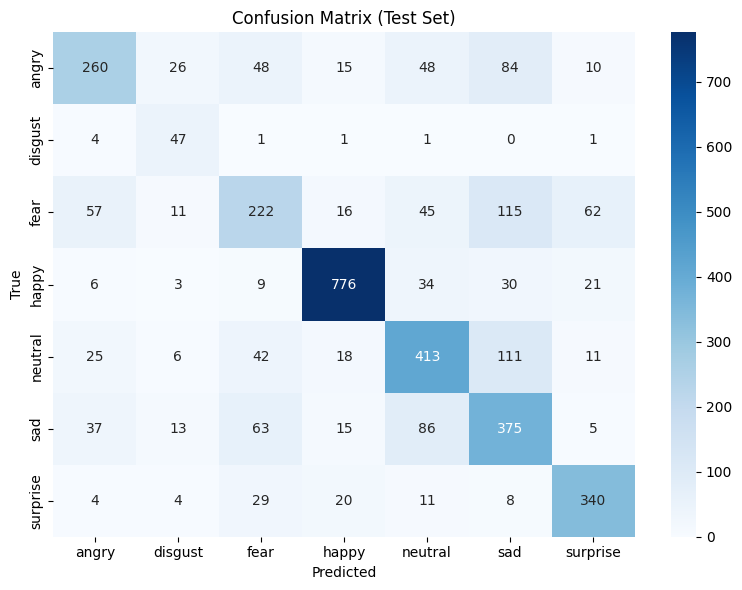


Classification Report (Test Set):
              precision    recall  f1-score   support

       angry       0.66      0.53      0.59       491
     disgust       0.43      0.85      0.57        55
        fear       0.54      0.42      0.47       528
       happy       0.90      0.88      0.89       879
     neutral       0.65      0.66      0.65       626
         sad       0.52      0.63      0.57       594
    surprise       0.76      0.82      0.79       416

    accuracy                           0.68      3589
   macro avg       0.64      0.69      0.65      3589
weighted avg       0.68      0.68      0.68      3589



In [ ]:

y_true = []; y_probs = []
for batch_imgs, batch_labels in test_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_probs.append(preds); y_true.append(batch_labels.numpy())

y_true = np.concatenate(y_true); y_probs = np.concatenate(y_probs)
y_pred = np.argmax(y_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Test Set)'); plt.tight_layout(); plt.show()

print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


## 12) ROC Curves (OvR) with AUCs

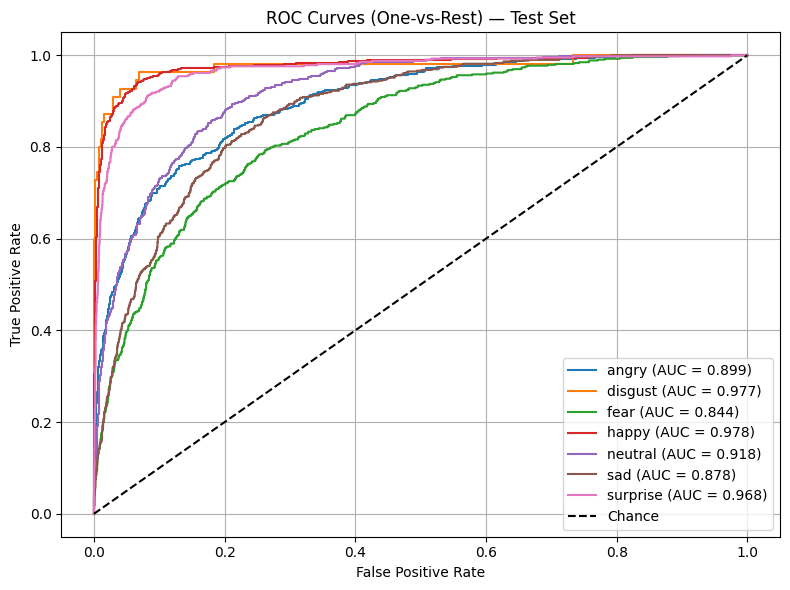

Per-class AUCs:
  angry: 0.899
  disgust: 0.977
  fear: 0.844
  happy: 0.978
  neutral: 0.918
  sad: 0.878
  surprise: 0.968


In [ ]:

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

Y_test_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

plt.figure(figsize=(8,6))
roc_aucs = {}
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(Y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_aucs[CLASS_NAMES[i]] = roc_auc
    plt.plot(fpr, tpr, label=f"{CLASS_NAMES[i]} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) — Test Set'); plt.legend(loc='lower right'); plt.grid(True); plt.tight_layout(); plt.show()

print("Per-class AUCs:")
for k, v in roc_aucs.items():
    print(f"  {k}: {v:.3f}")


## 13) Save Metadata (optional)

## 14) Switch to ResNet50

In [ ]:

# To use ResNet50: set BACKBONE = "resnet50" in the Training Config cell above,
# then rerun Model -> Train -> Evaluate cells.
